In [1]:
import numpy as np
from scipy.special import expit

def create_parameters(grid_dim):
    # Node parameter tensor
    node_params = np.zeros((grid_dim, grid_dim))
    value = -1
    for r in xrange(0, grid_dim):
        for c in xrange(0, grid_dim):
            node_params[r, c] = value
            value = -value 
            
    # Edge parameter tensor
    edge_params = np.zeros((grid_dim, grid_dim, grid_dim, grid_dim))
    value = 0.5
    for r in xrange(0, grid_dim):
        for c in xrange(0, grid_dim):
            edge_params[r, c, r, (c + 1) % grid_dim] = value # right
            edge_params[r, c, r, (c - 1) % grid_dim] = value # left
            edge_params[r, c, (r + 1) % grid_dim, c] = value # down
            edge_params[r, c, (r - 1) % grid_dim, c] = value # up
             
    return node_params, edge_params

def run_gibbs_epoch(X, node_params, edge_params):
    grid_dim = X.shape[0]
    
    for r in xrange(0, grid_dim):
        for c in xrange(0, grid_dim):
            # Compute p(X[r, c] = 1 | rest)
            p = node_params[r, c]
            p += edge_params[r, c, r, (c + 1) % grid_dim] * \
                X[r, (c + 1) % grid_dim]
            p += edge_params[r, c, r, (c - 1) % grid_dim] * \
                X[r, (c - 1) % grid_dim]
            p += edge_params[r, c, (r + 1) % grid_dim, c] * \
                X[(r + 1) % grid_dim, c]
            p += edge_params[r, c, (r - 1) % grid_dim, c] * \
                X[(r - 1) % grid_dim, c]
            p = expit(p)
            # Sample X[r, c] | rest
            X[r, c] = np.random.rand() < p
            
    return X

def gibbs_estimate(grid_dim, burnin_epochs=1000, sample_epochs=5000):
    # Create parameters
    node_params, edge_params = create_parameters(grid_dim)
    
    # Randomly initialize grid
    X = np.random.randint(0, 2, (grid_dim, grid_dim))
    
    # Keep track of samples
    samples = np.zeros((sample_epochs, grid_dim, grid_dim))
    
    for epoch in xrange(burnin_epochs):
        X = run_gibbs_epoch(X, node_params, edge_params)
    
    for epoch in xrange(sample_epochs):
        X = run_gibbs_epoch(X, node_params, edge_params)
        samples[epoch] = X
    
    # Estimate moments from samples
    moments = samples.mean(axis=0)
    
    return moments
             
grid_dim = 7
estimate = gibbs_estimate(grid_dim)
print estimate

[[ 0.6274  0.9176  0.6726  0.9188  0.6728  0.9188  0.6384]
 [ 0.9126  0.6948  0.9158  0.6932  0.905   0.694   0.9138]
 [ 0.6598  0.9004  0.6876  0.9094  0.699   0.9072  0.6782]
 [ 0.9146  0.6808  0.9082  0.6924  0.9094  0.6762  0.9178]
 [ 0.6638  0.907   0.6896  0.9066  0.6854  0.906   0.6666]
 [ 0.9196  0.6946  0.9014  0.6942  0.91    0.6932  0.9076]
 [ 0.6172  0.909   0.6638  0.9098  0.6644  0.912   0.632 ]]


In [2]:
n_iters = 10
grid_dim = 7
estimates = np.zeros((n_iters, grid_dim, grid_dim))

for iter in xrange(n_iters):
    estimates[iter] = gibbs_estimate(grid_dim)
    
mean = estimates.mean(axis=0)
std_dev = np.sqrt(((estimates - mean) ** 2).mean(axis=0))
print std_dev

[[ 0.00611362  0.00308701  0.01024851  0.0035715   0.00729342  0.00270118
   0.00748   ]
 [ 0.00180233  0.0057221   0.00459395  0.00606313  0.00345925  0.00531522
   0.0022698 ]
 [ 0.00500404  0.00426825  0.00788388  0.00345346  0.00719336  0.00315525
   0.00750746]
 [ 0.00328396  0.00674211  0.00337307  0.00704829  0.00253109  0.00650341
   0.00681883]
 [ 0.00525601  0.0041612   0.00559285  0.00365453  0.00213813  0.00215267
   0.00613319]
 [ 0.0037694   0.00864659  0.00405048  0.00605776  0.00274379  0.00660815
   0.00295405]
 [ 0.00738875  0.00318302  0.00763783  0.0045817   0.00614999  0.004603
   0.00550378]]


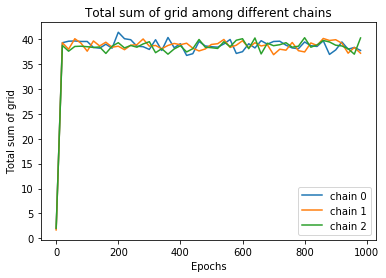

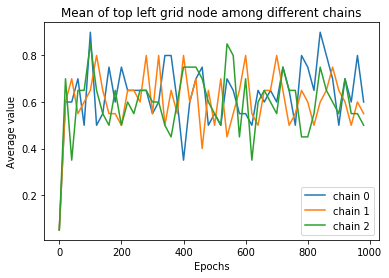

In [3]:
import matplotlib.pyplot as plt

# Experiment to figure out good mixing time
n_chains = 3
max_epochs = 1000
frequency = 20
X = np.random.randint(0, 2, (n_chains, grid_dim, grid_dim))
node_params, edge_params = create_parameters(grid_dim)

statistics = np.zeros((max_epochs / frequency, n_chains, 2))
total_sum = np.zeros(n_chains)
top_left_value = np.zeros(n_chains)

for epoch in xrange(max_epochs):
    for chain in xrange(n_chains):
        X[chain] = run_gibbs_epoch(X[chain], node_params, edge_params)
        total_sum[chain] += X[chain].sum()
        top_left_value[chain] += X[chain, 0, 0]
        if epoch % frequency == 0:
            statistics[epoch / frequency, chain, 0] = \
                total_sum[chain] / frequency
            statistics[epoch / frequency, chain, 1] = \
                top_left_value[chain] / frequency
            total_sum[chain] = 0
            top_left_value[chain] = 0
        
for chain in xrange(n_chains):
    plt.plot(xrange(0, max_epochs, frequency), statistics[:, chain, 0], 
             label="chain {}".format(chain))
plt.title("Total sum of grid among different chains")
plt.xlabel("Epochs")
plt.ylabel("Total sum of grid")
plt.legend()
plt.show()

for chain in xrange(n_chains):
    plt.plot(xrange(0, max_epochs, frequency), statistics[:, chain, 1], 
             label="chain {}".format(chain))
plt.title("Mean of top left grid node among different chains")
plt.xlabel("Epochs")
plt.ylabel("Average value")
plt.legend()
plt.show()

[[ 0.6358476   0.92153887  0.67167005  0.92285662  0.67167005  0.92153887
   0.6358476 ]
 [ 0.92153887  0.69782662  0.91543083  0.69741955  0.91543083  0.69782662
   0.92153887]
 [ 0.67167005  0.91543083  0.6967338   0.91636164  0.6967338   0.91543083
   0.67167005]
 [ 0.92285662  0.69741955  0.91636164  0.69693044  0.91636164  0.69741955
   0.92285662]
 [ 0.67167005  0.91543083  0.6967338   0.91636164  0.6967338   0.91543083
   0.67167005]
 [ 0.92153887  0.69782662  0.91543083  0.69741955  0.91543083  0.69782662
   0.92153887]
 [ 0.6358476   0.92153887  0.67167005  0.92285662  0.67167005  0.92153887
   0.6358476 ]]

0.00741358223508


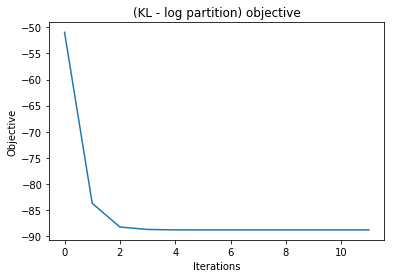

In [4]:
from scipy.stats import binom

def variational_estimate(grid_dim, threshold=1e-9):
    # Create parameters
    node_params, edge_params = create_parameters(grid_dim)
    
    # Randomly initialize parameters
    tau = np.random.rand(grid_dim, grid_dim)
    
    # TODO check if objective is good
    def objective():
        objective = -np.sum(binom.entropy(1, tau))
        objective -= np.sum(node_params * tau)
        for r1 in xrange(grid_dim):
            for c1 in xrange(grid_dim):
                for r2 in xrange(grid_dim):
                    for c2 in xrange(grid_dim):
                        objective -= edge_params[r1, c1, r2, c2] * \
                            tau[r1, c1] * tau[r2, c2]
        return objective
    
    def update_tau():
        for r in xrange(grid_dim):
            for c in xrange(grid_dim):
                p = node_params[r, c]
                p += edge_params[r, c, r, (c + 1) % grid_dim] * \
                    tau[r, (c + 1) % grid_dim]
                p += edge_params[r, c, r, (c - 1) % grid_dim] * \
                    tau[r, (c - 1) % grid_dim]
                p += edge_params[r, c, (r + 1) % grid_dim, c] * \
                    tau[(r + 1) % grid_dim, c]
                p += edge_params[r, c, (r - 1) % grid_dim, c] * \
                    tau[(r - 1) % grid_dim, c]
                tau[r, c] = expit(p)
        
    old_tau = tau.copy()
    objectives = [objective()]
    update_tau()
    while np.mean(np.abs(tau - old_tau) > threshold):
        objectives.append(objective())
        old_tau = tau.copy()
        update_tau()

    return tau, objectives

grid_dim = 7
tau, objectives = variational_estimate(grid_dim)

print tau
print
print np.mean(np.abs(tau - estimates[0]))

plt.plot(xrange(len(objectives)), objectives)
plt.title("(KL - log partition) objective")
plt.xlabel("Iterations")
plt.ylabel("Objective")
plt.show()